# Машинное обучение, ФКН ВШЭ
## Практическое задание 10

### Общая информация

Дата выдачи: 22.04.2019

Мягкий дедлайн: 12.05.2019 08:00 MSK

Жёсткий дедлайн: 14.05.2019 23:59 MSK

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость», которая будет объявлена после жёсткого дедлайна. Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

В финальной версии ноутбука, которая отправляется для сдачи задания, должны быть быть выполнены следующие условия:
* все ячейки выполнены для представленной в ноутбуке версии кода;
* результаты выполнения ячеек отображены и согласованы с кодом;
* при повторном запуске ячеек результаты должны воспроизводиться с точностью до случайности.


### Формат сдачи

Задания сдаются через систему anytask. Посылка должна содержать:

* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

# Часть 1. Работа с данными


Мы будем работать с датасетом `20newsgroups`. В датасете содержится около 20 000 статей, разбитых на 20 классов. В ячейке ниже происходит загрузка датасета:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='all')
data = dataset["data"]
y = np.array(dataset["target"])
labels_names = {i: name for i, name in enumerate(dataset["target_names"])}

In [3]:
print("Target names: " + ", ".join(dataset["target_names"]))

Target names: alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc


Эти маски нам понадобятся позднее

In [4]:
train_mask = (np.random.uniform(size=len(data)) < 0.2)
test_mask = ~train_mask

**Задание 1**. Для работы с текстами нам нужно как-то построить их признаковое описание. По-простому это можно сделать как минимум тремя способами:
* посчитать tf-idf векторы;
* усреднить предобученные эмбеддинги (например, Word2Vec);
* обучить эмбеддинги самому (тот же Word2Vec) и усреднить их.

Кроме того, в каждом из этих случаев можно провести [стемминг](https://en.wikipedia.org/wiki/Stemming) токенов, а можно обойтись без него. Какие плюсы и минусы есть у стемминга?

В дальнейшем мы захотим обучить для этого датасета KMeans (мы надеемся, что в один кластер попадут документы с одной тематикой). Изучите датасет (его размер, размер текстов, тематики, пр.) и скажите, какие есть плюсы и минусы у каждого из трех описанных выше подходов.

In [5]:
sepLine = '\n' + '-'*100 + '\n'

In [6]:
print('Длина нашего датасета равна', len(y))
assert(len(y) == len(data))

Длина нашего датасета равна 18846


Посмотрим примеры текстов

In [7]:
print(*data[:3], sep=sepLine)

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


-------------------------------------------------------------------------------------------------

Выведем распределение тематик

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter

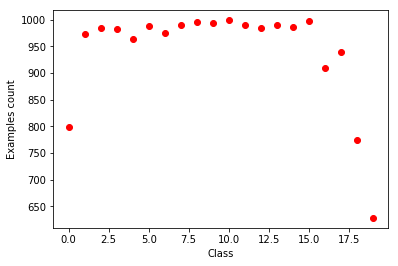

In [9]:
cnt = Counter(y)
cnt = np.array([cnt[i] for i in range(len(cnt))])
labels = list(labels_names[i] for i in range(len(labels_names)))
plt.plot(np.arange(len(cnt)), cnt, 'ro')
plt.xlabel('Class')
plt.ylabel('Examples count')
plt.show()

Видим, что кол-во примеров на каждую тематику примерно одинаковое, но есть редкие темы. Например, примеров статей с классом 19 не так много.

In [10]:
average = cnt.mean()
print('Среднее кол-во примеров на тему', average)
absDeviation = np.abs(cnt - average)
worstClasses = np.where(absDeviation > 100)[0]
print('Классы с сильным отклонением от среднего кол-ва примеров на этот класс:', list(worstClasses), sep='\n')

Среднее кол-во примеров на тему 942.3
Классы с сильным отклонением от среднего кол-ва примеров на этот класс:
[0, 18, 19]


Посмотрим на распределение размеров текстов

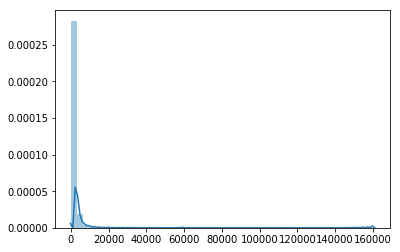

In [11]:
textSizes = np.array([len(text) for text in data])
sns.distplot(textSizes)

Возьмем логирифм от размеров

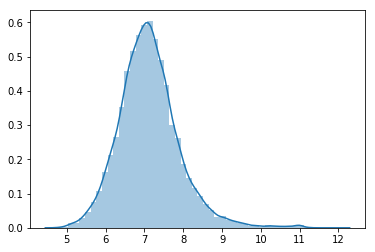

In [12]:
sns.distplot(np.log(textSizes))

In [13]:
print('Среднее кол-во символов в статье', textSizes.mean())

Среднее кол-во символов в статье 1902.5258940889314


__*Ответ:*__
* __TF-IDF.__
Плюсы: прост в понимании и реализации,позволяет выделить ключевые слова в тексте
Минусы: Требует большой выборки и затрат по памяти, не учитывает контекст, в котором употребляется слово

* __Предобученные эмбеддинги.__
Сильно зависит от выборки, на которой обучались. Если выборка имела такие же или шире тематики, то это плюс, однако в противном случае мы получим плохой результат

* __Самостоятельное обучение эмбеддингов.__
Важно правильно разлелить выборку на тренировочную и тестовую для получения положительного результата

**Задание 2**. Удалите из текстов email-адреса, приведите все к нижнему регистру, токенизируйте тексты с помощью `gensim.parsing.preprocessing.preprocess_string` (необходимые фильтры уже были импортированы) и обучите на полученных данных `gensim.models.word2vec.Word2Vec` с параметрами по умолчанию и 30 итерациями в обучении. Дополнительно обучите еще один Word2Vec на текстах с произведенным стеммингом, используйте `nltk.stem.porter.PorterStemmer`.

In [14]:
from gensim.parsing.preprocessing import (
    preprocess_string,
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    remove_stopwords,
)
from gensim.models.word2vec import Word2Vec
from nltk.stem.porter import PorterStemmer
import re

EMAIL_REGEXP = r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"
FILTERS = [strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords]

tokenized_data = ['']*len(data)
for i in range(len(data)):
    tokenized_data[i] = preprocess_string(re.sub(EMAIL_REGEXP, '', data[i].lower()), filters=FILTERS)

stemmed_data = ['']*len(data)
stemmer = PorterStemmer()
for i in range(len(data)):
    stemmed_data[i] = [stemmer.stem(word) for word in tokenized_data[i]]


w2v = Word2Vec(tokenized_data)
w2v.train(tokenized_data, total_examples=w2v.corpus_count, epochs=30)

stemmed_w2v = Word2Vec(stemmed_data)
stemmed_w2v.train(stemmed_data, total_examples=stemmed_w2v.corpus_count, epochs=30)


C:\Users\nikitos\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(76466069, 83900910)

In [15]:
print(tokenized_data[0])


['mamatha', 'devineni', 'ratnam', 'subject', 'pens', 'fans', 'reactions', 'organization', 'post', 'office', 'carnegie', 'mellon', 'pittsburgh', 'pa', 'lines', 'nntp', 'posting', 'host', 'po', 'andrew', 'cmu', 'edu', 'sure', 'bashers', 'pens', 'fans', 'pretty', 'confused', 'lack', 'kind', 'posts', 'recent', 'pens', 'massacre', 'devils', 'actually', 'bit', 'puzzled', 'bit', 'relieved', 'going', 'end', 'non', 'pittsburghers', 'relief', 'bit', 'praise', 'pens', 'man', 'killing', 'devils', 'worse', 'thought', 'jagr', 'showed', 'better', 'regular', 'season', 'stats', 'lot', 'fo', 'fun', 'watch', 'playoffs', 'bowman', 'let', 'jagr', 'lot', 'fun', 'couple', 'games', 'pens', 'going', 'beat', 'pulp', 'jersey', 'disappointed', 'islanders', 'lose', 'final', 'regular', 'season', 'game', 'pens', 'rule']


Напишите функцию, которая принимала бы на вход токенизированные тексты и для каждого текста возвращала бы усредненный эмбеддинг токенов. Если для какого-то токена в модели нет эмбеддинга, считайте его равным нулевому вектору.

In [16]:
def average_embedding(texts, embedder):
    '''
    texts -- список из списков токенов (каждый вложенный список соответствует тексту)
    embedder -- объект с полем wv, у которого определен оператор [], и с полем vector_size
    return: матрица усредненных эмбеддингов
    '''
    matrix = np.zeros((len(texts), embedder.vector_size))
    for i in range(len(texts)):
        toEmbed = list(filter(lambda x: x in embedder.wv, texts[i]))
        matrix[i] = embedder.wv[toEmbed].mean(axis=0)
    
    return matrix

Воспользуйтесь этой функцией, чтобы составить матрицу средних word2vec-эмбеддингов для наших текстов.

In [17]:
w2v_embed = average_embedding(tokenized_data, w2v)
w2v_embed_stem = average_embedding(stemmed_data, stemmed_w2v)

**Задание 3 (бонус, 0.5 баллов)**. Классической рекламой Word2Vec является "осмысленность арифметических действий" над эмбеддингами: утверждается, например, что $\text{embedding(king)} - \text{embedding(man)} + \text{embedding(woman)} \approx \text{embedding(queen)}$. Можете попробовать поискать такие отношения в вашей обученной модели. Получилось ли у вас что-нибудь найти? Подсказка: воспользуйтесь `w2v.wv.similar_by_vector`

In [18]:
def search_logic(main_word, sub_feature, add_feature):
    approx_embed = stemmed_w2v.wv[main_word] - stemmed_w2v.wv[sub_feature] + stemmed_w2v.wv[add_feature]
    print(*stemmed_w2v.wv.similar_by_vector(approx_embed), sep='\n')
def add_words(first, second):
    print(*stemmed_w2v.wv.similar_by_vector(stemmed_w2v.wv[first] + stemmed_w2v.wv[second]), sep='\n')

In [19]:
search_logic('brother', 'man', 'woman')

('brother', 0.7497957944869995)
('sister', 0.6172333359718323)
('woman', 0.5313887596130371)
('widow', 0.5177730321884155)
('marina', 0.5153866410255432)
('wife', 0.5062803030014038)
('neighbor', 0.47786131501197815)
('lyuda', 0.4699888527393341)
('daughter', 0.46525275707244873)
('grandmoth', 0.4641135334968567)


In [20]:
search_logic('mother', 'woman', 'man')

('mother', 0.6436505317687988)
('man', 0.6091278791427612)
('redempt', 0.45833730697631836)
('spirit', 0.44665664434432983)
('transgress', 0.43874692916870117)
('righteous', 0.4089311361312866)
('possessor', 0.40708789229393005)
('hath', 0.40008723735809326)
('lord', 0.3969830274581909)
('imput', 0.39544665813446045)


In [21]:
add_words('computer', 'man')

('man', 0.9414128065109253)
('woman', 0.552932858467102)
('throne', 0.4582611620426178)
('earth', 0.4487497806549072)
('jealou', 0.44008365273475647)
('creatur', 0.41543808579444885)
('wicked', 0.4098215103149414)
('virtuou', 0.4097098112106323)
('lover', 0.40919816493988037)
('peopl', 0.40868061780929565)


*Осмысленность можно увидеть даже тут: человек с компьютером -- бог*

Некая логика видна и тут: хакер без преступления -- программист в майкрософт

**Задание 4**. В дальнейшем нам понадобится уметь считать качество кластеризации, будем использовать supervised-метрики. Напишите функцию, вычисляющую BCubed-precision, BCubed-recall и BCubed-F1

In [22]:
def bcubed_metrics(labels, clusters):
    '''
    labels -- настоящие метки документов
    clusters -- соответственно, кластеры для документов
    return: precision, recall, f1
    '''
    cluster_result = clusters[:, np.newaxis] == clusters[np.newaxis, :]
    precision = 0
    recall = 0
    n_labels = len(labels)
    cnt = Counter(labels)
    for i in range(n_labels):
        cluster_ind = cluster_result[i]
        label = labels[i]
        in_one_clusster_same = (labels[cluster_ind] == label).sum()
        cluster_size = cluster_ind.sum()
        
        precision += in_one_clusster_same / cluster_size / n_labels
        recall += in_one_clusster_same / cnt[label] / n_labels
    
    return precision, recall, 2 * precision * recall / (precision + recall)
        
    

Чтобы понимать, насколько плохой/хорошей получилась кластеризация, нужно как минимум понимать, насколько она лучше случайной кластеризации. Случайно кластеризуйте объекты и посчитайте метрики.

In [23]:
rand_cluster = np.random.randint(0, len(labels) - 1, size=len(y))
bcubed_metrics(y, rand_cluster)

(0.051375456388527016, 0.05357136874425051, 0.05245043887915278)

Напишите функцию, которая рисовала бы график распределения меток в каждом из кластеров, например, как на картинке.
<img src="example.png" align="center">

In [64]:
def plot_labels_distribution(labels, clusters, labels_names):
    '''
    labels -- настоящие классы документов
    clusters -- соответственно, кластеры для документов
    labels_names -- словарь, сопоставляющий индексу класса его название
    '''
    plt.figure(figsize=(12, 6))
    unique_clusters = np.unique(clusters) 
    unique_classes = np.unique(labels)
    #print(unique_classes)
    n_classes = len(unique_classes)
    n_clusters = len(unique_clusters)
    dist_matrix = np.zeros((n_classes, n_clusters))
    
    for j, cluster in enumerate(unique_clusters):
        cluster_inds = clusters == cluster
        cluster_elems = labels[cluster_inds]
        cnt = Counter(cluster_elems)
        #print(cnt)
        cluster_size = len(cluster_elems)
        for i, class_ind in enumerate(unique_classes):
            dist_matrix[i, j] = cnt[class_ind] / cluster_size
    
    below_th = np.zeros((n_clusters))
    for i, class_ind in enumerate(unique_classes):
        #print(class_ind)
        plt.bar(np.arange(n_clusters), dist_matrix[i], label=labels_names[class_ind], bottom=below_th)
        below_th += dist_matrix[i]
    
    plt.title("Labels distribution in cluster")
    plt.xlabel("Cluster")
    plt.ylim((0, 1))
    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.xticks(np.arange(n_clusters))
    plt.show()
    #print(dist_matrix)

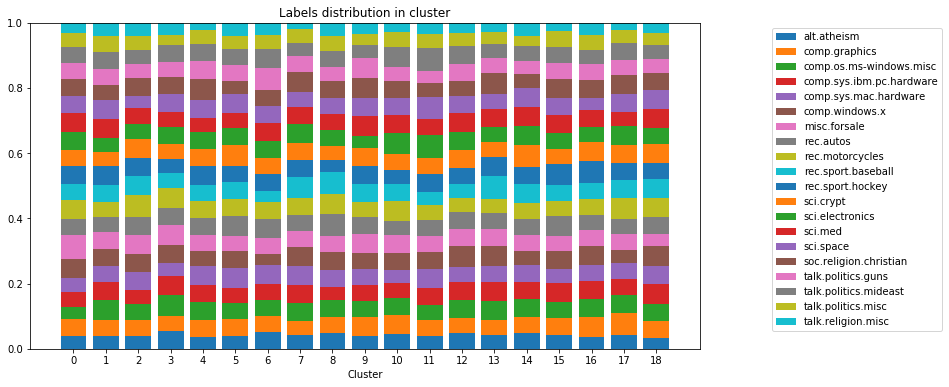

In [65]:
plot_labels_distribution(y, rand_cluster, labels_names)

# Часть 2. Кластеризация

**Задание 5**. Обучите на усредненных word2vec-векторах (и для текстов со стеммингом, и без него) KMeans на 20 кластеров (с параметрами по умолчанию), измерьте качество кластеризации (BCubed-метрики) и постройте график распределения меток по кластерам. Попробуйте поперебирать параметры KMeans, не меняя число кластеров. Получилось ли у вас добиться сильного выигрыша?

In [26]:
from sklearn.cluster import KMeans

Bcube metrics: (0.33903647850301455, 0.31915212992891806, 0.32879394402046086)


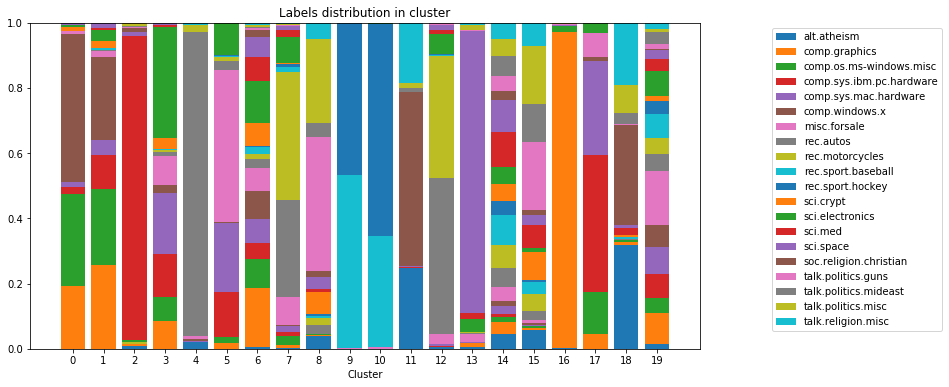

In [66]:
kmeans = KMeans(n_clusters=20, random_state=42).fit(w2v_embed)

print("Bcube metrics:", bcubed_metrics(y, kmeans.labels_))
      
plot_labels_distribution(y, kmeans.labels_, labels_names)

In [28]:
algorithm = ["auto", "elkan"]
max_iter = [100, 200, 400]


for algo in algorithm:
    for i in max_iter:
        print("Algorithm:", algo, "Max iter:", i)
        
        kmeans = KMeans(n_clusters=20, random_state=42, algorithm=algo, max_iter=i).fit(w2v_embed)
        print("Bcube metrics:", bcubed_metrics(y, kmeans.labels_))
        
        print(sepLine)

Algorithm: auto Max iter: 100
Bcube metrics: (0.33903647850301455, 0.31915212992891806, 0.32879394402046086)

----------------------------------------------------------------------------------------------------

Algorithm: auto Max iter: 200
Bcube metrics: (0.33903647850301455, 0.31915212992891806, 0.32879394402046086)

----------------------------------------------------------------------------------------------------

Algorithm: auto Max iter: 400
Bcube metrics: (0.33903647850301455, 0.31915212992891806, 0.32879394402046086)

----------------------------------------------------------------------------------------------------

Algorithm: elkan Max iter: 100
Bcube metrics: (0.33903647850301455, 0.31915212992891806, 0.32879394402046086)

----------------------------------------------------------------------------------------------------

Algorithm: elkan Max iter: 200
Bcube metrics: (0.33903647850301455, 0.31915212992891806, 0.32879394402046086)

----------------------------------------

In [29]:
algorithm = ["auto", "elkan"]
max_iter = [100, 200, 400]


for algo in algorithm:
    for i in max_iter:
        print('Parameters')
        print("\tAlgorithm:", algo, "Max iter:", i)
        kmeans = KMeans(n_clusters=20, random_state=42, algorithm=algo, max_iter=i).fit(w2v_embed_stem)
        print("Bcube metrics:", bcubed_metrics(y, kmeans.labels_))
        
        print(sepLine)

Parameters
	Algorithm: auto Max iter: 100
Bcube metrics: (0.3446316308259308, 0.32120047933143475, 0.33250377482666227)

----------------------------------------------------------------------------------------------------

Parameters
	Algorithm: auto Max iter: 200
Bcube metrics: (0.3446268891725363, 0.32119459276129986, 0.3324984138417033)

----------------------------------------------------------------------------------------------------

Parameters
	Algorithm: auto Max iter: 400
Bcube metrics: (0.3446268891725363, 0.32119459276129986, 0.3324984138417033)

----------------------------------------------------------------------------------------------------

Parameters
	Algorithm: elkan Max iter: 100
Bcube metrics: (0.3446316308259308, 0.32120047933143475, 0.33250377482666227)

----------------------------------------------------------------------------------------------------

Parameters
	Algorithm: elkan Max iter: 200
Bcube metrics: (0.3446268891725363, 0.32119459276129986, 0.3324984

Помог ли стемминг улучшить качество кластеризации? Насколько сильно?

**_Ответ_**:
Нет, метрики остались примерно на одинаковом уровне

Все следующие эксперименты проводите на текстах без стемминга. 

**Задание 6**. Скорее всего, выигрыш оказался очень маленьким. Возможно, в усредненных word2vec-векторах содержится слишком мало информации, и этим объясняется низкое качество модели? Чтобы проверить это, обучите логистическую регрессию на предсказание настоящих меток документов. Для разбиения на обучающую и тестовую выборки воспользуйтесь масками `train_mask`, `test_mask`. Измерьте BCubed-метрики на тестовой части для кластеризации и логистической регрессии. Для кластеризации также постройте график распределения меток по кластерам.

In [30]:
from sklearn.linear_model import LogisticRegression
x_train = np.array(data)[train_mask]
y_train = y[train_mask]

def preprocess_data(data):
    tokenized_data = ['']*len(data)
    for i in range(len(data)):
        tokenized_data[i] = preprocess_string(re.sub(EMAIL_REGEXP, '', data[i].lower()), filters=FILTERS)
    return tokenized_data

        
preproc_x_train = preprocess_data(x_train)
w2v = Word2Vec(preproc_x_train)
w2v.train(preproc_x_train, total_examples=w2v.corpus_count, epochs=30)
w2v_x_train = average_embedding(preproc_x_train, w2v)


clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(w2v_x_train, y_train)

x_test = np.array(data)[test_mask]
y_test = y[test_mask]    


preproc_x_test = preprocess_data(x_test)
w2v_x_test = average_embedding(preproc_x_test, w2v)

C:\Users\nikitos\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(0.8168468607610005, 0.8163852571652394, 0.8166159937311553)


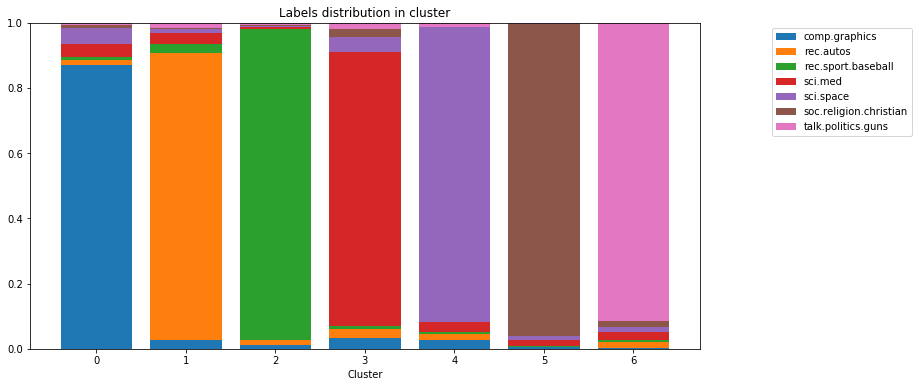

In [67]:
y_pred = clf.predict(w2v_x_test)
print(bcubed_metrics(y_test, y_pred))
plot_labels_distribution(y_test, y_pred, labels_names)

Bcube metrics: (0.6805171177722926, 0.3041206818390273, 0.42037656880882546)


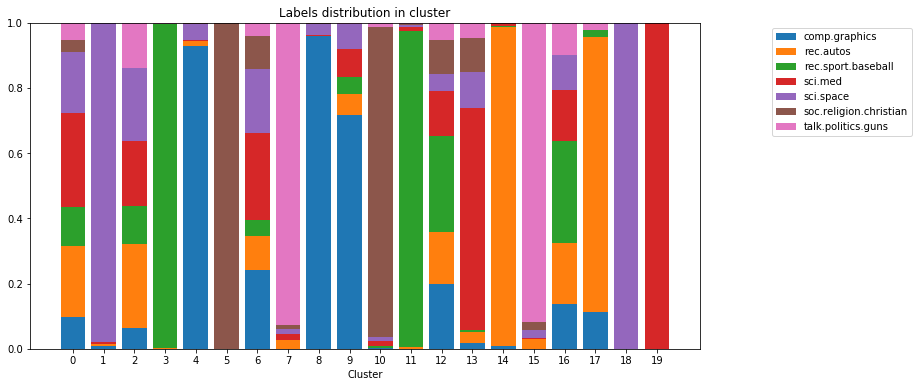

In [68]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(w2v_x_test)
print("Bcube metrics:", bcubed_metrics(y_test, kmeans.labels_))
      
plot_labels_distribution(y_test, kmeans.labels_, labels_names)

Посмотрите на размер кластеров. Сильно ли они отличаются друг от друга? Есть ли очень большие или очень маленькие кластеры?

In [69]:
print(Counter(kmeans.labels_))
print(Counter(y_pred))

Counter({13: 540, 0: 530, 5: 426, 1: 417, 14: 413, 2: 412, 15: 367, 3: 342, 6: 268, 7: 265, 8: 260, 10: 253, 11: 248, 9: 209, 4: 193, 16: 102, 12: 95, 19: 55, 17: 44, 18: 2})
Counter({13: 809, 7: 806, 1: 794, 15: 781, 9: 771, 14: 742, 16: 738})


Нельзя сказать, что есть прям очень большие или маленькие кластеры, но отличия явно есть

Можно ли объяснить плохую кластеризацию тем, что усредненный Word2Vec - слишком плохое признаковое пространство? Если такого утверждения сделать нельзя, дело может быть в слишком похожих метках документов. Попробуйте оставить в выборках только документы с 7 сильно отличающимися классами. Обучите KMeans и логистическую регрессию на этих данных; изменился ли зазор между кластеризацией и классификацией?

In [70]:
distinct_labels = {
    "comp.graphics", "rec.autos", "rec.sport.baseball",
    "sci.space", "sci.med", "soc.religion.christian", "talk.politics.guns"
}


new_data_ind = list(filter(lambda x: labels_names[y[x]] in distinct_labels, range(len(data))))
new_data = [data[i] for i in new_data_ind]
new_y = np.array([y[i] for i in new_data_ind])

In [71]:
train_mask = (np.random.uniform(size=len(new_data)) < 0.2)
test_mask = ~train_mask


x_train = np.array(new_data)[train_mask]
y_train = new_y[train_mask]

In [72]:
preproc_x_train = preprocess_data(x_train)
w2v = Word2Vec(preproc_x_train)
w2v.train(preproc_x_train, total_examples=w2v.corpus_count, epochs=30)
w2v_x_train = average_embedding(preproc_x_train, w2v)


clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(w2v_x_train, y_train)

x_test = np.array(new_data)[test_mask]
y_test = new_y[test_mask]    


preproc_x_test = preprocess_data(x_test)
w2v_x_test = average_embedding(preproc_x_test, w2v)

C:\Users\nikitos\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(0.8355190560329615, 0.8347157407169242, 0.8351172051938709)


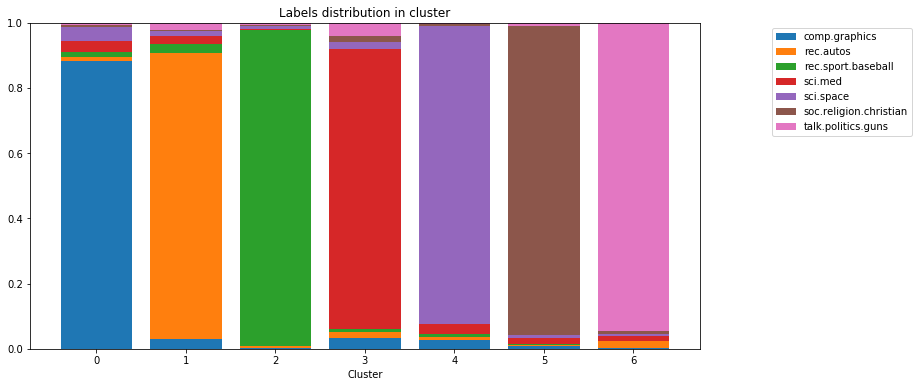

In [73]:
y_pred = clf.predict(w2v_x_test)
print(bcubed_metrics(y_test, y_pred))
plot_labels_distribution(y_test, y_pred, labels_names)


Bcube metrics: (0.4913525186243784, 0.4822077813307603, 0.4867372013178031)


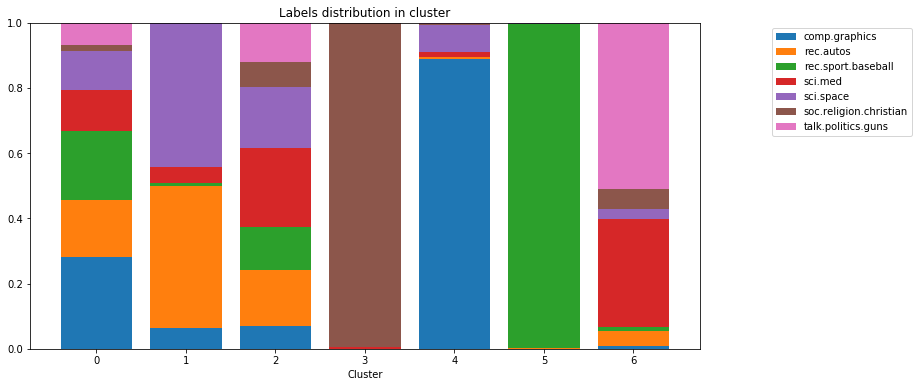

In [75]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(w2v_x_test)
print("Bcube metrics:", bcubed_metrics(y_test, kmeans.labels_))
      
plot_labels_distribution(y_test, kmeans.labels_, labels_names)

Ответьте на вопросы:
1. Судя по графикам, какие классы сложно отделяются от других? Какие классы похожи друг на друга? Какие классы легко отделяются от других?
2. Возросли ли метрики у кластеризации при отборе 7 отличных друг от друга меток?
3. Возросли ли метрики у классификации при отборе 7 отличных друг от друга меток? Почему?
4. Можно ли объяснить плохую кластеризацию неудачным признаковым пространством? Схожестью меток?

**_Ответ:_**

* Классы, имеющие схожие тематики очень сложно различать методом kMeans
* Да, возросли
* Да, возросли, потому, что чем больше отличий, тем проще классифицировать
* Скорее схожестью меток. Скорее всего, даже человек будет ошибаться, потому что неоднозначные классы, а мы используем простые методы

# Часть 3. Latent Dirichlet Allocation

**Задание 7**. Обучать LDA на тех текстах, которые мы сейчас имеем, - очень медленно, поскольку в них очень много уникальных слов. Чтобы это исправить, мы оставим в текстах только те слова, которые чаще всего встречаются в нашем корпусе. Напишите функцию, которая принимает на вход тексты и количество слов, которые нужно оставить, и выкидывает слова, которые не попали в _глобальный_ топ по всему корпусу:

In [77]:
def leave_top_words(texts, n_words):
    '''
    texts -- набор текстов (список списков токенов)
    n_words -- сколько слов из топа нужно оставить
    return: набор текстов с удаленными словами, которые не вошли в топ
    '''
    
    return [list(map(lambda x: x[0], Counter(text).most_common(n_words))) for text in texts]

Сделайте два набора текстов: в одном оставьте 3000 слов, а в другом 6000 слов.

In [78]:
data_3000 = leave_top_words(tokenized_data, 3000)
data_6000 = leave_top_words(tokenized_data, 6000)

Обучите `gensim.models.ldamodel.LdaModel` (для этого вам также понадобится `gensim.corpora.Dictionary`) с 20 темами на обоих наборах текстов.

In [79]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel


def get_lda(data):
    d = Dictionary(data)
    corpus = [d.doc2bow(text) for text in data]
    return LdaModel(corpus, num_topics=20)

In [80]:
lda_3000 = get_lda(data_3000)
lda_6000 = get_lda(data_6000)

Метод `inference` в LDA возвращает для каждого текста вероятности тем. Напишите функцию, которая принимала бы обученную LDA-модель и корпус, возвращая самый вероятный топик для каждого текста. Убедитесь, что разница в качестве (по BCubed) между наборами на 3000 и 6000 слов незначительна. Это будет означать, что можно работать с набором на 3000 слов.

In [81]:
def get_topics(lda_model, corpus):
    '''
    lda_model -- обученный инстанс LdaModel
    corpus -- корпус
    return: наиболее вероятный топик для каждого текста из корпуса
    '''
    
    return np.argmax(lda_model.inference(corpus)[0], axis=1)

In [84]:
def make_corpus(data):
    d = Dictionary(data)
    corpus = [d.doc2bow(text) for text in data]
    return corpus

In [85]:
y_pred_3000 = get_topics(lda_3000, make_corpus(data_3000))
y_pred_6000 = get_topics(lda_6000, make_corpus(data_6000))

In [86]:
bcubed_metrics(y, y_pred_3000)

(0.18001713019560092, 0.2825430407721641, 0.21991771254377265)

In [87]:
bcubed_metrics(y, y_pred_6000)

(0.20311162226028148, 0.3615864058571569, 0.2601121230252928)

**Задание 8**. Попытайтесь выбить из LDA больше качества. Для этого переберите по полной квадратной сетке параметры `iterations` и `num_passes` (скажем, по сетке 3х3, не стоит ставить слишком большие значения). Для каждой модели посчитайте ELBO и bcubed-метрики и сохраните их: они нам понадобятся в дальнейшем. Постройте графики зависимости ELBO от `iterations` при разных `num_passes` (3 кривые на одном графике) и наоборот.

In [42]:
# Your code here

Постройте график зависимости BCubed-F1 от ELBO. Для лучшей (по BCubed-F1) LDA-модели постройте график распределения меток в кластерах.

In [43]:
# Your code here

Ответьте на вопросы:
1. Посмотрите на размер кластеров в LDA. Сильно ли они отличаются друг от друга? Есть ли очень большие или очень маленькие кластеры?
2. Как влияют на ELBO `iterations` и `passes`? 
3. Есть ли какая-нибудь зависимость между ELBO и BCubed-F1? Можем ли мы обучать LDA, смотря только на ELBO?
4. Сравните тематическое моделирование при помощи LDA и кластеризацию при помощи KMeans.

**Задание 9**. С помощью `pyLDAvis.gensim` визуализируйте найденные моделью темы и попытайтесь описать некоторые из них.

In [44]:
# Your code here

# Часть 4. Три подхода к обучению

**Задание 10**. Вы обучили две unsupervised-модели и, скорее всего, не получили очень хорошего качества. Более того, вы попытались обучить логистическую регрессию на небольшом количестве размеченных данных и, скорее всего, получили качество заметно лучше. Попробуйте теперь обучить логистическую регрессию на tf-idf векторах. Сравните качество с логистической регрессией на усредненных word2vec-векторах. Для разбиения на обучающую и тестовую выборки пользуйтесь масками `train_mask` и `test_mask`.

In [45]:
# Your code here

Попробуем применить semi-supervised подход. На тех же данных примените self-training метод, в основе которого лежит логистическая регресиия. Напомним, что это означает:

1. Обучаем модель на размеченной выборке;
2. Применяем модель к неразмеченной выборке, выбираем некоторое количество объектов, в которых модель уверена больше всего. Добавляем к размеченной выборке эти объекты, присваивая им метки, которые предсказала модель;
3. Повторяем несколько раз.

В качестве неразмеченной части возьмите тестовую выборку. Посчитайте метрики

In [46]:
# Your code here

Ответьте на вопросы:
1. Как методы ранжируются по итоговому качеству? Почему именно так?
2. На каком признаковом пространстве логистическая регрессия дает лучшее качество? Почему?

**_Ответ_**: